# Machine learning and natural language processing on politics texts

## Hiro Miyake  

### 4/4/2019

# 1. Insights

First of all, all the insights I derive here are based on the data at hand, so they only illuminate what is going on within the confines where the data came from. Extending the conclusions drawn here to other contexts may be inappropriate.

I first list the insights obtained. After this section, I describe the steps and code used to arrive at these insights.

## Insight 1: Republicans tweet about 'good', 'great', 'house' and 'tax', Democrats tweet about 'women', 'join', 'care' and 'family'

This insight was gained by analyzing Twitter data. I applied standard text preprocessing to all of the tweets, used a bag of words approach along with term frequency-inverse document frequency (tfidf) and built a logistic regression model to predict the party of the tweeter. By examining the model coefficients, I was able to extract the most relevant words that predict party affiliation. From these words, it looks like Democrat tweets are more feminine and Republican tweets are more masculine, and the gender ratio of the two parties represented in the data are consistent with this view.

## Insight 2: Women tweet alike more than men tweet alike

I compiled all the tweets for each person in the data set and performed k-means clustering on the text data to see how each user are close to each other. Naively you might expect the clusters would split along party lines, but the most interesting clustering seems to be one where all the women are in one cluster, and all the men are in their own separate clusters. So perhaps women have a more consistent Twitter messaging trend compared to men.

## Insight 3: Maryland bills that are enacted tend to be about replacing existing laws

I wanted to determine the characteristics of bills that were enacted. This could be hugely useful for people who want certain laws enacted, because they can influence the bill so that it is likely to pass. Perhaps unsurprisingly, it was hard to find anything definitive (otherwise I should probably start my own consulting company to help people pass bills). Nonetheless, a logistic regression model on the bill text and other features seem to suggest that bills that pass tend to have the word "replace" in them. To say anything definitive, more analysis is necessary, but at a high level, this may mean that it is easier to change existing law rather than creating a new law where there are no existing laws on the matter at hand. So if you want a new law passed, you might want to tie it into an existing law and replace it rather than try to get a completely new law enacted.

# 2. Analysis and Code

Insights 1 and 2 are based on the Twitter data, and insight 3 is based on the bill data. I am using Python 2.

Load all the libraries I use first.

In [1]:
%matplotlib inline

from collections import defaultdict

import pandas as pd
import numpy as np

import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

## 2.1 Insight 1 Analysis and Code

First let's load the Twitter data.

In [2]:
twitter = pd.read_csv('leg_twitter.csv')

Let's take a look at the first few rows.

In [3]:
twitter.head()

,Unnamed: 0,user_id,screen_name,id,text,retweet_count,favorite_count,entities,name,gender,party
0,0,16256269,virginiafoxx,25221573803773952,The House is currently honoring Rep. Giffords ...,1,0,"{""symbols"": [], ""user_mentions"": [], ""hashtags...",Virginia Ann Foxx,female,republican
1,1,16256269,virginiafoxx,25212608336371712,"China testing a new stealth fighter, while Def...",0,0,"{""symbols"": [], ""user_mentions"": [], ""hashtags...",Virginia Ann Foxx,female,republican
2,2,16256269,virginiafoxx,385845599708278784,Thank you to Capitol Police for keeping us saf...,8,6,"{""symbols"": [], ""user_mentions"": [], ""hashtags...",Virginia Ann Foxx,female,republican
3,3,16256269,virginiafoxx,28892770564,Interested in a nomination to a U.S. military/...,0,0,"{""symbols"": [], ""user_mentions"": [], ""hashtags...",Virginia Ann Foxx,female,republican
4,4,16256269,virginiafoxx,28799103005,At Mt Tabor HS in Forsyth County this morning ...,1,0,"{""symbols"": [], ""user_mentions"": [], ""hashtags...",Virginia Ann Foxx,female,republican


Let's see how many Republican and Democrat tweets there are in the data set.

In [4]:
twitter.party.value_counts(dropna = False)

republican    8626
democrat      8432
Name: party, dtype: int64

The two classes are fairly evenly divided. That's good for class prediction.

What I want to do is try to predict the party of the tweeter based on tweet features. By using a logistic regression model, I can look at the coefficients and determine which features are the most predictive and statistically significant.

So let's binarize the party variable for prediction.

In [5]:
twitter['party_binary'] = twitter.party.map(lambda x: 1 if x == 'democrat' else 0)

Now let's do some preprocessing of the text of the tweets for prediction.

I perform some standard text pre-processing to perform machine learning on text data.

1. Convert text to Python string.
2. Remove punctuation.
3. Convert text to utf-8.
4. Convert text to lowercase.
5. Stem the words so that different tenses and such are counted as the same word.  
https://www.datacamp.com/community/tutorials/stemming-lemmatization-python
6. Remove stopwords. I have included Python magic words such as `pass` and `except`, although this is certainly a solvable problem.  
https://pythonprogramming.net/stop-words-nltk-tutorial/  
https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
7. Remove numbers from the text.

For a quick analysis, these should be reasonable things to do.

In [6]:
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
my_stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}

# Add other words to the list, like Python magic words
my_stopwords.update({'pass','except'})

porter = PorterStemmer()

def text_preprocessing(x):
    y = str(x).translate(None, string.punctuation).decode('utf-8').lower().split()
    y = [porter.stem(w) for w in y if w not in my_stopwords]
    y = [w for w in y if w not in my_stopwords and not w.isdigit()] # 2nd stopword cleaning for stemming issues
    return ' '.join(y)

In [7]:
twitter_corpus = twitter['text'].map(text_preprocessing)

Here's how the text was transformed.

In [8]:
print 'Before: ' + twitter.text[0]
print 'After: ' + twitter_corpus[0]

Before: The House is currently honoring Rep. Giffords and those gunned down in Saturday's horrific violence.
After: hous current honor rep gifford gun saturday horrif violenc


Now I get the term frequency, inverse document frequency (tf-idf) of the corpus using bag of words. Naively you could use the number of occurences of a given word to predict, but this could favor tweets that are longer and therefore have more words in general. tf-idf accounts for this.  
https://scikit-learn.org/stable/modules/feature_extraction.html  
https://pythonprogramminglanguage.com/bag-of-words/  
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

I restrict the number of words to the top 30, so that the model building behaves well on my laptop. Then I turn the tf-idf matrix into a pandas dataframe.

In [9]:
twitter_vectorizer = TfidfVectorizer(max_features = 30)
twitter_mat = twitter_vectorizer.fit_transform(twitter_corpus)

/Users/hiro/anaconda/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [10]:
twitter_tfidf_df = pd.DataFrame(twitter_mat.toarray(), columns = twitter_vectorizer.get_feature_names())

Here's what the tfidf dataframe looks like.

In [11]:
twitter_tfidf_df.head()

,american,amp,bill,care,congress,day,famili,get,good,great,...,support,tax,thank,time,today,us,vote,women,work,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.679488,0.0,0.0,0.733686,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


Now combine the tfidf dataframe with the `party_binary` column that I created from the original dataframe.

In [12]:
twitter_party_df = pd.concat([twitter[['party_binary']], twitter_tfidf_df], axis = 1)

Make sure the outcome variables still make sense, i.e., are only 0 or 1.

In [13]:
twitter_party_df.party_binary.value_counts(dropna = False)

0    8626
1    8432
Name: party_binary, dtype: int64

These are the same numbers I found with the original party column, so things are looking good.

I use logistic regression to predict the party from the text. This allows me to extract the important words to predict both parties. The important thing here for me is interpretability rather than prediction accuracy. If I wanted good prediction accuracy, I could have used for example a random forest model.

In particular, I use the statsmodels library, which has a logistic regression routine and an interface similar to R.  
https://www.statsmodels.org/stable/index.html

First I have to build the formula.

In [14]:
twitter_formula = 'party_binary ~ american'
for i, col in enumerate(twitter_party_df):
    if col != 'party_binary' and col != 'american':
        twitter_formula = twitter_formula + ' + ' + col
print twitter_formula

party_binary ~ american + amp + bill + care + congress + day + famili + get + good + great + help + hous + join + live + make + need + new + peopl + rt + see + support + tax + thank + time + today + us + vote + women + work + year


Then I fit the model.

In [15]:
twitter_results = smf.logit(twitter_formula, data=twitter_party_df).fit()
twitter_results.summary()

Optimization terminated successfully.
         Current function value: 0.647323
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           party_binary   No. Observations:                17058
Model:                          Logit   Df Residuals:                    17027
Method:                           MLE   Df Model:                           30
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                 0.06602
Time:                        16:48:46   Log-Likelihood:                -11042.
converged:                       True   LL-Null:                       -11823.
                                        LLR p-value:                3.703e-310
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2614      0.029     -8.928      0.000      -0.319      -0.204
american       0.7488      0.113      6.622      0.000       0.527       0.970
amp            0.5730      0.076      7.562      0.000       0.424       0.721
bill           0.0781      0.100      0.780      0.435      -0.118       0.274
care           0.9703      0.134      7.234      0.000       0.707       1.233
congress      -0.4974      0.118     -4.215      0.000      -0.729      -0.266
day            0.3777      0.111      3.401      0.001       0.160       0.595
famili         0.8625      0.126      6.820      0.000       0.615       1.110
get            0.3874      0.120      3.227      0.001       0.152       0.623
good          -1.2806      0.143     -8.972      0.000      -1.560      -1.001
great         -1.1917      0.115    -10.405      0.000      -1.416      -0.967
help           0.5501      0.119      4.640      0.000       0.318       0.782
hous          -1.1834      0.109    -10.811      0.000      -1.398      -0.969
join           1.4847      0.121     12.266      0.000       1.247       1.722
live          -0.5198      0.113     -4.607      0.000      -0.741      -0.299
make           0.3338      0.131      2.553      0.011       0.078       0.590
need           0.1873      0.114      1.636      0.102      -0.037       0.412
new           -0.6712      0.115     -5.840      0.000      -0.896      -0.446
peopl          0.1773      0.128      1.384      0.166      -0.074       0.429
rt             0.5915      0.057     10.296      0.000       0.479       0.704
see            0.2640      0.103      2.565      0.010       0.062       0.466
support        0.5360      0.117      4.571      0.000       0.306       0.766
tax           -1.1738      0.139     -8.441      0.000      -1.446      -0.901
thank          0.1745      0.081      2.151      0.031       0.016       0.334
time           0.1373      0.115      1.190      0.234      -0.089       0.363
today          0.4406      0.085      5.170      0.000       0.274       0.608
us             0.2164      0.100      2.154      0.031       0.019       0.413
vote          -0.2424      0.104     -2.319      0.020      -0.447      -0.038
women          2.2662      0.163     13.935      0.000       1.947       2.585
work           0.5657      0.108      5.246      0.000       0.354       0.777
year           0.9857      0.132      7.486      0.000       0.728       1.244
==============================================================================
"""

Let's make sure the model is not completely meaningless by looking at the area under the curve (AUC) of the receiver operating characteristic (ROC) curve.

In [16]:
twitter_pred = twitter_results.predict(twitter_party_df) # Predict probability
twitter_score = roc_auc_score(twitter_party_df['party_binary'], twitter_pred)
print 'Area under the ROC curve: ' + str(twitter_score)

Area under the ROC curve: 0.6622889417765716


The value is reasonably above 0.5, so the model is likely to have some predictive power. Recall that an AUC of 0.5 means that the model is as good as random guessing.

Now I want to know which words are most predictive of a tweet being from a Democrat or Republican. More positive the coefficient, the more strongly it predicts a Democrat, and more negative the coefficient, the more strongly it predicts a Republican. I also only want to consider statistically significant features, so I only consider those features with p-values less than $0.05/N$, where $N$ is the total number of features in the model. This is the Bonferroni correction, and is conservative but a quick way to deal with cases when you have many features, since by chance some may appear statistically significant.

In [17]:
twitter_params = pd.DataFrame([twitter_results.params, twitter_results.pvalues], index = ['params','pvalues'])
twitter_params = twitter_params.transpose()
twitter_params[twitter_params.pvalues < 0.05/(twitter_party_df.shape[1] - 1)].sort_values(by = ['params'])

,params,pvalues
good,-1.280560,2.913749e-19
great,-1.191728,2.351310e-25
hous,-1.183380,3.045139e-27
tax,-1.173831,3.134566e-17
new,-0.671178,5.222452e-09
live,-0.519776,4.092724e-06
congress,-0.497364,2.503168e-05
Intercept,-0.261413,4.342634e-19
day,0.377749,6.720112e-04
get,0.387359,1.248888e-03


If we consider the strongest predictors, we see that Republicans tend to tweet about 'good', 'great', 'house' and 'tax', and Democrats tend to tweet about 'women', 'join', 'care', and 'family' (I ignore 'year' since that seems meaningless).

Note that of the 8 people included in the data, 1 out of 4 are female for the Republicans, and 3 out of 4 are female for the Democrats. This most likely explains why the feminine words are predictive of a Democrat. If the data included all males, it's possible these words would not be very predictive of party. In particular, there are many more tweets from female than male for the Democrats as we see in the table below.

In [18]:
pd.crosstab(twitter.gender,twitter.party)

party,democrat,republican
gender,,
female,7645,3285
male,787,5341


## 2.2 Insight 2 Analysis and Code

For the second insight, I want to try to cluster people into groups according to their tweets, to see if there are interesting groupings of people tweeting like each other. For this purpose, I use k-means clustering on tfidf, an unsupervised learning method.

First, let's see how many unique people there are.

In [19]:
twitter.name.unique()

array(['Virginia Ann Foxx', 'Kyrsten Sinema', 'Andy Biggs',
       'Bruce Westerman', 'Janice D. Schakowsky', 'Nancy J. Pinkin',
       'John Abney Culberson', 'Stephen Fenberg'], dtype=object)

We see that there are 8 people to consider.

For the text data, I reuse the preprocessed text data from insight 1 and add it to the original dataframe.

In [20]:
twitter['corpus'] = twitter_corpus

Now, I essentially want to combine all of the tweets from the same person, so I can to tfidf on all tweets from a given person. I do this below.

In [21]:
name_tweet = defaultdict(str)
for index, row in twitter.iterrows():
    if row['name'] not in name_tweet:
        name_tweet[row['name']] = row['corpus']
    else:
        name_tweet[row['name']] += ' ' + row['corpus']

Convert this to a dataframe to see what we have.

In [22]:
name_tweet_df = pd.DataFrame({'name': name_tweet.keys(),'tweet': name_tweet.values()})
name_tweet_df

,name,tweet
0,Andy Biggs,great news texa judg grant emerg injunct tuesd...
1,John Abney Culberson,congratul good friend georg mick tremend succe...
2,Nancy J. Pinkin,scenic earth day realiti red tide week massiv ...
3,Kyrsten Sinema,may militaryappreciationmonth say thank servic...
4,Virginia Ann Foxx,hous current honor rep gifford gun saturday ho...
5,Bruce Westerman,said block grant tax cut good block grant woul...
6,Stephen Fenberg,proud repres folk boulder counti priorit susta...
7,Janice D. Schakowsky,rt wendycnc nice see rep janschakowski capitol...


Let's see which parties they are associated with.

In [23]:
twitter[['name','party']].drop_duplicates()

,name,party
0,Virginia Ann Foxx,republican
3285,Kyrsten Sinema,democrat
6710,Andy Biggs,republican
7437,Bruce Westerman,republican
8737,Janice D. Schakowsky,democrat
12292,Nancy J. Pinkin,democrat
12957,John Abney Culberson,republican
16271,Stephen Fenberg,democrat


Now I do tfidf on the 8 text rows, with 1000 features.

In [24]:
twitter_name_vectorizer = TfidfVectorizer(max_features = 1000)
twitter_name_mat = twitter_name_vectorizer.fit_transform(name_tweet.values())

Convert this into a dataframe to see what we have.

In [25]:
twitter_name_tfidf_df = pd.DataFrame(twitter_name_mat.toarray(), columns = twitter_name_vectorizer.get_feature_names())
twitter_name_tfidf_df

,1st,2nd,4job,4th,530630pm,5th,7th,abl,abort,aca,...,write,wrong,wrote,ye,year,yesterday,yet,young,yr,zika
0,0.002510,0.001871,0.000000,0.000000,0.0000,0.003141,0.000000,0.001871,0.002657,0.000935,...,0.000935,0.000000,0.001047,0.002510,0.009204,0.006694,0.001673,0.001673,0.000837,0.000000
1,0.022932,0.007324,0.000000,0.003662,0.0000,0.000000,0.003279,0.008788,0.000000,0.000000,...,0.019774,0.004099,0.013118,0.055691,0.033415,0.006552,0.023587,0.003931,0.016380,0.000000
2,0.007212,0.002687,0.000000,0.016123,0.0000,0.003008,0.006016,0.000000,0.000000,0.008061,...,0.000000,0.000000,0.009024,0.004808,0.055292,0.014424,0.009616,0.014424,0.026444,0.000000
3,0.008904,0.000000,0.000000,0.002765,0.0768,0.001238,0.021046,0.001106,0.000000,0.000553,...,0.001659,0.001857,0.000619,0.011378,0.072717,0.013356,0.009893,0.003463,0.004452,0.000000
4,0.009278,0.002766,0.074348,0.001383,0.0000,0.053407,0.002322,0.003457,0.017679,0.000691,...,0.004149,0.005418,0.001548,0.003093,0.051341,0.046392,0.003093,0.009278,0.010516,0.002240
5,0.003973,0.005922,0.000000,0.011103,0.0000,0.000000,0.000000,0.001480,0.004206,0.002961,...,0.002221,0.003315,0.000000,0.000662,0.019867,0.006622,0.001987,0.003311,0.002649,0.001199
6,0.004698,0.012252,0.000000,0.007001,0.0000,0.001959,0.001959,0.007001,0.000000,0.001750,...,0.001750,0.003919,0.000000,0.017225,0.028186,0.014093,0.003132,0.018791,0.004698,0.000000
7,0.002381,0.002129,0.000000,0.001597,0.0000,0.005363,0.000596,0.005855,0.024951,0.037259,...,0.003726,0.010130,0.007746,0.001905,0.069999,0.019524,0.013809,0.010476,0.012857,0.032769


Now I apply k-means clustering. I start with k = 2.

In [26]:
## https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
## https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html
kmn = KMeans(n_clusters=2, n_init = 100)
kmn.fit(twitter_name_mat.toarray()).labels_

array([1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

This means that Andy Biggs tweets in a unique way, and everybody else tweets in a similar way. I would have naively thought 2 clusters would split along party lines, or along gender lines. I tried different cluster numbers, but the most interesting is with 5 clusters.

In [27]:
kmn = KMeans(n_clusters=5, n_init = 100)
kmn.fit(twitter_name_mat.toarray()).labels_

array([1, 3, 0, 0, 0, 2, 4, 0], dtype=int32)

Recall who the entries correspond to.

In [28]:
name_tweet_df.name

0              Andy Biggs
1    John Abney Culberson
2         Nancy J. Pinkin
3          Kyrsten Sinema
4       Virginia Ann Foxx
5         Bruce Westerman
6         Stephen Fenberg
7    Janice D. Schakowsky
Name: name, dtype: object

All the men have fragmented into their own clusters (4 of them), and the remaining 5th cluster is all females. So females tweet like one another, and men are tweeting each their own ways.

## 2.3 Insight 3 Analysis and Code

I tried a few different angles, but most of them did not lead to interesting findings, so I do not include those deadend analyses. I describe below the analysis that led to the most interesting finding. That is, predicting whether a Maryland bill passes or not with text and other features.

First I load the bill schema and see what's in it.

In [29]:
bill_schema = pd.read_json('data_schema.json')
bill_schema

,properties,type
actions,"{u'type': u'object', u'id': u'/actions', u'pro...",object
bill_type,"{u'type': u'string', u'id': u'/bill_type'}",object
chamber,"{u'type': u'string', u'id': u'/chamber'}",object
committees,"{u'type': u'object', u'id': u'/committees', u'...",object
description,"{u'type': u'string', u'id': u'/description'}",object
documents,"{u'type': u'object', u'id': u'/documents', u'p...",object
id,"{u'type': u'integer', u'id': u'/id'}",object
session,"{u'type': u'string', u'id': u'/session'}",object
sponsors,"{u'items': [{u'type': u'object', u'id': u'/spo...",object
state,"{u'type': u'string', u'id': u'/state'}",object


In [30]:
bill_schema['properties']['actions']

{u'id': u'/actions',
 u'properties': {u'enacted': {u'id': u'/actions/enacted', u'type': u'date'},
  u'failed': {u'id': u'/actions/failed', u'type': u'date'},
  u'introduced': {u'id': u'/actions/introduced', u'type': u'date'},
  u'passed_lower': {u'id': u'/actions/passed_lower', u'type': u'date'},
  u'passed_upper': {u'id': u'/actions/passed_upper', u'type': u'date'},
  u'resolution_passed': {u'id': u'/actions/resolution_passed',
   u'type': u'date'},
  u'vetoed': {u'id': u'/actions/vetoed', u'type': u'date'}},
 u'type': u'object'}

Now I load the actual bill data.

In [31]:
bill = pd.read_json('data.json', lines=True)

Let's take a look at the first few lines.

In [32]:
bill.head()

,actions,bill_type,chamber,committees,description,documents,id,session,sponsors,state,title,votes
0,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_upper': u'Senate Committee on Bud...,"Establishing the Commission on Tax Policy, Ref...",{u'1': u'AN ACT concerning Commission on Tax P...,1,2013,"[{u'party': u'Republican Party', u'type': u'co...",md,"Commission on Tax Policy, Reform, and Fairness","{u'chamber_lower': {u'yes_vote': [u'Turner, V...."
1,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,upper,{u'committee_upper': u'Senate Committee on Rul...,Requiring a local department of social service...,{u'1': u'AN ACT concerning Children with Devel...,2,2013,"[{u'party': u'Democratic Party', u'type': u'co...",md,Children with Developmental Disabilities in St...,"{u'chamber_upper': {u'yes_vote': [u'Rosapepe',..."
2,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_lower': u'House Committee on Envi...,Providing that the Maryland Vehicle Law does n...,{u'0': u'AN ACT concerning Vehicle Laws Charle...,3,2013,"[{u'party': None, u'type': u'primary', u'name'...",md,Vehicle Laws - Charles County - Golf Cart Zones,{}
3,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,upper,{u'committee_upper': u'Senate Committee on Rul...,Authorizing the creation of a State Debt not t...,{u'0': u'AN ACT concerning Creation of a State...,4,2013,"[{u'party': u'Democratic Party', u'type': u'pr...",md,Creation of a State Debt - Maryland Artificial...,{}
4,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_lower': u'House Committee on Appr...,"Altering the definition of ""tuition"" to includ...",{u'0': u'AN ACT concerning Foster Care Recipie...,5,2013,"[{u'party': u'Democratic Party', u'type': u'pr...",md,Foster Care Recipients - Waiver of Tuition and...,{}


Let's take a look at the first documents variable.

In [33]:
bill.documents[0]

{u'0': u'AN ACT concerning Commission on Tax Policy, Reform, and Fairness FOR the purpose of establishing the Commission on Tax Policy, Reform, and Fairness; specifying the membership of the Commission; providing for the appointment of a Senate cochair and House cochair of the Commission; providing for the staffing of the Commission; prohibiting a member of the Commission from receiving certain compensation, but authorizing the reimbursement of certain expenses; requiring the Commission to study, consider, and make recommendations regarding certain matters; requiring the Commission to report its findings and recommendations to the Governor and the General Assembly on or before a certain date; providing for the termination of this Act; and generally relating to the Commission on Tax Policy, Reform, and Fairness. SECTION 1. BE IT ENACTED BY THE GENERAL ASSEMBLY OF MARYLAND, That: (a) There is a Commission on Tax Policy, Reform, and Fairness. (b) The Commission consists of the following m

We see that there are two entries in this dictionary. The second looks almost identical to the first. This second one is probably just a revision of the first one. So if we do any text analysis, we should probably just keep one of the versions.

Let's see how many rows are for each state.

In [34]:
bill['state'].value_counts(dropna=False)

ca    9548
md    5221
Name: state, dtype: int64

I want to focus on Maryland bills.

In [35]:
bill = bill[bill.state == 'md']

Let's look at the `bill_type` variable.

In [36]:
bill['bill_type'].value_counts(dropna=False)

bill          5190
resolution      31
Name: bill_type, dtype: int64

Most of them are bills, but some are resolutions. For this analysis, let's focus just on bills and drop the resolutions.

In [37]:
bill = bill[bill.bill_type == 'bill']

Let's take a more detailed look at the actions column.

In [38]:
bill.actions[0]

{u'enacted': u'null',
 u'failed': u'2013-03-27',
 u'introduced': u'2013-02-08',
 u'passed_lower': u'2013-03-21',
 u'passed_upper': u'null',
 u'resolution_passed': u'null',
 u'vetoed': u'null'}

I dropped all of the resolutions, so there should not be rows with a non-null `resolution_passed` value.

In [39]:
bill['resolution_passed'] = bill.actions.map(lambda x: x['resolution_passed'])
bill.resolution_passed.value_counts(dropna=False)

null    5190
Name: resolution_passed, dtype: int64

This is true, so good.

I want to predict whether a bill was enacted or not (essentially passing), so I create a new column that is 1 for enacted and 0 otherwise.

In [40]:
bill['enacted'] = bill.actions.map(lambda x: 0 if x['enacted'] == r'null' else 1)
bill.enacted.value_counts(dropna=False)

0    4500
1     690
Name: enacted, dtype: int64

There are 690 bills that passed, 4500 bills that failed.

Let's look at the sponsor values.

In [41]:
bill.sponsors[0]

[{u'name': u"O'Donnell", u'party': u'Republican Party', u'type': u'cosponsor'},
 {u'name': u'McMillan', u'party': u'Republican Party', u'type': u'cosponsor'},
 {u'name': u'Dumais', u'party': u'Democratic Party', u'type': u'primary'},
 {u'name': u'Myers', u'party': u'Republican', u'type': u'cosponsor'},
 {u'name': u'Simmons', u'party': u'Democratic', u'type': u'cosponsor'},
 {u'name': u'Cardin', u'party': u'Democratic', u'type': u'cosponsor'},
 {u'name': u'Serafini', u'party': u'Republican Party', u'type': u'cosponsor'},
 {u'name': u'Fisher', u'party': u'Republican Party', u'type': u'cosponsor'},
 {u'name': u'Luedtke', u'party': u'Democratic Party', u'type': u'cosponsor'},
 {u'name': u'Hixson', u'party': u'Democratic Party', u'type': u'cosponsor'},
 {u'name': u'George', u'party': u'Republican', u'type': u'cosponsor'},
 {u'name': u'F. Turner', u'party': u'Democratic Party', u'type': u'cosponsor'},
 {u'name': u'Afzali', u'party': u'Republican Party', u'type': u'cosponsor'}]

There are many sponsors. I will make a feature for each row with the number of sponsors.

Highest number of sponsors: 87
Lowest number of sponsors: 1


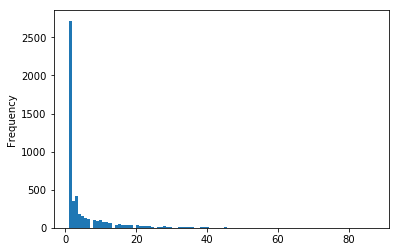

In [42]:
bill['sponsor_num'] = bill.sponsors.map(lambda x: len(x))
print 'Highest number of sponsors: ' + str(max(bill.sponsor_num))
print 'Lowest number of sponsors: ' + str(min(bill.sponsor_num))
bill.sponsor_num.plot.hist(bins=100)

Most bills have very few sponsors, but some have a lot. I deal with this imbalance later by taking the log of this value.

Common sense suggests there should be only one primary sponsor, but I want to check this.

In [43]:
def get_primary_sponsor_number(x):
    res = 0
    for i in x:
        if i['type'] == 'primary':
            res += 1
    return res

bill['primary_sponsor_num'] = bill.sponsors.map(get_primary_sponsor_number)
bill.primary_sponsor_num.value_counts()

1     5189
18       1
Name: primary_sponsor_num, dtype: int64

Surprisingly, there is one bill with 18 primary sponsors. Since it's only one, I drop this bill.

In [44]:
bill = bill[bill.primary_sponsor_num == 1]
bill.shape

(5189, 16)

As discovered earlier, the documents column is a dictionary with a number of entries. I create a feature with the total number of documents for each bill.

In [45]:
bill['document_num'] = bill.documents.map(lambda x: len(x))
bill.document_num.value_counts()

1    3095
2    1393
3     529
4     172
Name: document_num, dtype: int64

Let's check the breakdown of enacted with the number of documents.

In [46]:
pd.crosstab(bill.enacted, bill.document_num)

document_num,1,2,3,4
enacted,,,,
0,3095,1393,10,2
1,0,0,519,170


Wow, this is pretty stark. Rows with 3 or 4 documents most certainly were enacted, and those with 1 or 2 documents failed with 100% certainty. If we make this a feature, we can predict the outcome with almost 100% accuracy, but this is meaningless, since laws that are enacted probably end up getting revised and necessarily have at least 3 revisions. Although this is mildly interesting to know, it most likely has no value in helping a bill be enacted. So I will not use this as a feature in the modeling. Furthermore, I will only take the last document for text analysis.

In [47]:
bill['document_final'] = bill.documents.map(lambda x: x[str(len(x) - 1)])

Do tfidf on the bill documents. I use the function `text_preprocessing` which I created earlier for the Twitter data.

In [48]:
# Test the procedure
text_preprocessing(bill.document_final[0])

u'act concern commiss tax polici reform fair purpos establish commiss tax polici reform fair specifi membership commiss provid appoint senat cochair hous cochair commiss provid staf commiss prohibit member commiss receiv certain compens author reimburs certain expens requir commiss studi consid make recommend regard certain matter requir commiss report find recommend governor gener assembl certain date provid termin act gener relat commiss tax polici reform fair section enact gener assembl maryland commiss tax polici reform fair b commiss consist follow member two member senat maryland appoint presid senat hous bill two member hous deleg appoint speaker hous comptrol treasuri comptrol designe secretari budget manag secretari designe repres maryland associ counti repres maryland chamber commerc one economist appoint governor one member faculti univers maryland school public polici appoint governor one member faculti univers maryland robert h smith school busi appoint governor two member

Here I do the full text preprocessing. This takes some time.

In [49]:
bill_corpus = bill.document_final.map(text_preprocessing)

I can save this to a text file so I can load it next time without having to preprocess it.

In [50]:
# https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.Series.to_csv.html
## bill_corpus.to_csv('bill_md_corpus_final.csv')

I apply tfidf on this data and keep the top 100 words.

In [51]:
bill_vectorizer = TfidfVectorizer(max_features = 100)
bill_mat = bill_vectorizer.fit_transform(bill_corpus)

In [52]:
bill_tfidf_df = pd.DataFrame(bill_mat.toarray(), columns = bill_vectorizer.get_feature_names())
bill_tfidf_df.head()      # Check the first few rows

,accord,act,administr,amend,amount,annot,appli,applic,appropri,approv,...,titl,trust,unit,use,vehicl,violat,volum,within,work,year
0,0.025960,0.060458,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022759
1,0.007848,0.009138,0.277317,0.031038,0.000000,0.043671,0.000000,0.068990,0.038326,0.042787,...,0.036668,0.0,0.0,0.000000,0.000000,0.0,0.043964,0.008306,0.000000,0.220161
2,0.000000,0.043007,0.052205,0.029215,0.000000,0.025691,0.000000,0.000000,0.000000,0.000000,...,0.086284,0.0,0.0,0.103626,0.670883,0.0,0.025863,0.000000,0.000000,0.000000
3,0.047226,0.109983,0.000000,0.000000,0.261458,0.000000,0.022721,0.023065,0.028829,0.025748,...,0.000000,0.0,0.0,0.022084,0.000000,0.0,0.000000,0.024992,0.238996,0.020701
4,0.000000,0.065867,0.000000,0.044744,0.125267,0.039347,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.039611,0.000000,0.000000,0.148772


Let's take a look at the original dataframe again and decide which features to keep.

In [53]:
bill.head()

,actions,bill_type,chamber,committees,description,documents,id,session,sponsors,state,title,votes,resolution_passed,enacted,sponsor_num,primary_sponsor_num,document_num,document_final
0,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_upper': u'Senate Committee on Bud...,"Establishing the Commission on Tax Policy, Ref...",{u'1': u'AN ACT concerning Commission on Tax P...,1,2013,"[{u'party': u'Republican Party', u'type': u'co...",md,"Commission on Tax Policy, Reform, and Fairness","{u'chamber_lower': {u'yes_vote': [u'Turner, V....",null,0,13,1,2,"AN ACT concerning Commission on Tax Policy, Re..."
1,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,upper,{u'committee_upper': u'Senate Committee on Rul...,Requiring a local department of social service...,{u'1': u'AN ACT concerning Children with Devel...,2,2013,"[{u'party': u'Democratic Party', u'type': u'co...",md,Children with Developmental Disabilities in St...,"{u'chamber_upper': {u'yes_vote': [u'Rosapepe',...",null,0,10,1,2,AN ACT concerning Children with Developmental ...
2,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_lower': u'House Committee on Envi...,Providing that the Maryland Vehicle Law does n...,{u'0': u'AN ACT concerning Vehicle Laws Charle...,3,2013,"[{u'party': None, u'type': u'primary', u'name'...",md,Vehicle Laws - Charles County - Golf Cart Zones,{},null,0,1,1,1,AN ACT concerning Vehicle Laws Charles County ...
3,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,upper,{u'committee_upper': u'Senate Committee on Rul...,Authorizing the creation of a State Debt not t...,{u'0': u'AN ACT concerning Creation of a State...,4,2013,"[{u'party': u'Democratic Party', u'type': u'pr...",md,Creation of a State Debt - Maryland Artificial...,{},null,0,1,1,1,AN ACT concerning Creation of a State Debt Mar...
4,"{u'vetoed': u'null', u'resolution_passed': u'n...",bill,lower,{u'committee_lower': u'House Committee on Appr...,"Altering the definition of ""tuition"" to includ...",{u'0': u'AN ACT concerning Foster Care Recipie...,5,2013,"[{u'party': u'Democratic Party', u'type': u'pr...",md,Foster Care Recipients - Waiver of Tuition and...,{},null,0,2,1,1,AN ACT concerning Foster Care Recipients Waive...


For the purposes of modeling, I keep the features `chamber`, `enacted`, and `sponsor_num`.

In [54]:
## https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html
bill_model = bill[['chamber','enacted','sponsor_num']].reset_index(drop=True)

I also add another feature, which is the number of words in the document.

In [55]:
bill_model['corpus_length'] = bill_corpus.map(lambda x: len(x.split()))

Let's see what the numbers look like.

In [56]:
bill_model.corpus_length.value_counts(dropna=False)

 384.0      54
 386.0      40
 385.0      38
NaN         32
 388.0      31
 391.0      26
 381.0      24
 383.0      23
 389.0      23
 387.0      22
 382.0      21
 395.0      21
 190.0      20
 192.0      20
 230.0      20
 397.0      19
 396.0      19
 241.0      19
 7.0        19
 180.0      18
 188.0      18
 175.0      17
 229.0      17
 378.0      17
 392.0      17
 135.0      17
 390.0      16
 300.0      16
 209.0      16
 393.0      16
            ..
 693.0       1
 12474.0     1
 1309.0      1
 1803.0      1
 12473.0     1
 5744.0      1
 12221.0     1
 2540.0      1
 94724.0     1
 785.0       1
 1030.0      1
 2118.0      1
 1216.0      1
 21.0        1
 1184.0      1
 19.0        1
 17.0        1
 3136.0      1
 828.0       1
 807.0       1
 68.0        1
 3207.0      1
 3446.0      1
 3258.0      1
 17278.0     1
 2444.0      1
 709.0       1
 2362.0      1
 1811.0      1
 1762.0      1
Name: corpus_length, Length: 1323, dtype: int64

We have a few NaNs. I set these to 0.

In [57]:
bill_model.corpus_length = bill_model.corpus_length.map(lambda x: 0 if np.isnan(x) else x)

In [58]:
bill_model.head(5)

,chamber,enacted,sponsor_num,corpus_length
0,lower,0,13,356.0
1,upper,0,10,1497.0
2,lower,0,1,310.0
3,upper,0,1,379.0
4,lower,0,2,279.0


I take the log of `sponsor_num` and `corpus_length` so they are of order 1.

In [59]:
bill_model.corpus_length = bill_model.corpus_length.map(lambda x: np.log(x + 1))
bill_model.sponsor_num = bill_model.sponsor_num.map(np.log)

In [60]:
bill_model.head(5)

,chamber,enacted,sponsor_num,corpus_length
0,lower,0,2.564949,5.877736
1,upper,0,2.302585,7.311886
2,lower,0,0.000000,5.739793
3,upper,0,0.000000,5.940171
4,lower,0,0.693147,5.634790


Let's visualize their distributions.

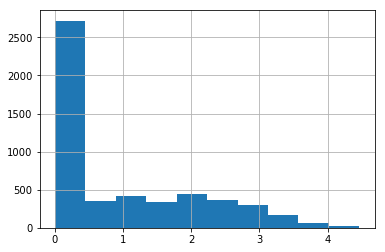

In [61]:
bill_model.sponsor_num.hist()

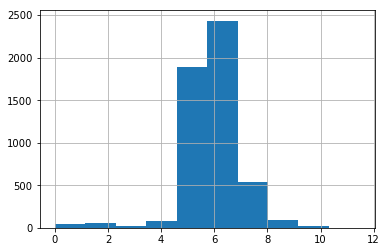

In [62]:
bill_model.corpus_length.hist()

They both look reasonable.

Now let's make a big dataframe for modeling.

In [63]:
bill_df = pd.concat([bill_model, bill_tfidf_df], axis = 1)
bill_df.head() # Check the first few rows

,chamber,enacted,sponsor_num,corpus_length,accord,act,administr,amend,amount,annot,...,titl,trust,unit,use,vehicl,violat,volum,within,work,year
0,lower,0,2.564949,5.877736,0.025960,0.060458,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.022759
1,upper,0,2.302585,7.311886,0.007848,0.009138,0.277317,0.031038,0.000000,0.043671,...,0.036668,0.0,0.0,0.000000,0.000000,0.0,0.043964,0.008306,0.000000,0.220161
2,lower,0,0.000000,5.739793,0.000000,0.043007,0.052205,0.029215,0.000000,0.025691,...,0.086284,0.0,0.0,0.103626,0.670883,0.0,0.025863,0.000000,0.000000,0.000000
3,upper,0,0.000000,5.940171,0.047226,0.109983,0.000000,0.000000,0.261458,0.000000,...,0.000000,0.0,0.0,0.022084,0.000000,0.0,0.000000,0.024992,0.238996,0.020701
4,lower,0,0.693147,5.634790,0.000000,0.065867,0.000000,0.044744,0.125267,0.039347,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.039611,0.000000,0.000000,0.148772


Let's build the formula.

In [64]:
# https://www.statsmodels.org/stable/index.html
# https://www.statsmodels.org/devel/examples/notebooks/generated/ols.html
bill_formula = 'enacted ~ chamber'
for i, col in enumerate(bill_df):
    if col != 'enacted' and col != 'chamber':
        bill_formula = bill_formula + ' + ' + col
print bill_formula

enacted ~ chamber + sponsor_num + corpus_length + accord + act + administr + amend + amount + annot + appli + applic + appropri + approv + articl + assembl + author + bill + board + bond + busi + certain + code + commiss + concern + counti + court + date + day + depart + determin + educ + effect + elect + employ + employe + enact + establish + facil + fee + follow + fund + gener + govern + health + hous + ii + iii + includ + individu + inform + insur + issu + law + licens + loan + local + maryland + may + mean + member + offic + oper + paragraph + person + plan + program + properti + provid + provis + public + purpos + regul + relat + repeal + replac + report + requir + sale + school + secretari + section + servic + shall + state + subject + subsect + subtitl + supplement + system + take + tax + term + time + titl + trust + unit + use + vehicl + violat + volum + within + work + year


Let's fit a logistic regression.

In [65]:
bill_results = smf.logit(bill_formula, data=bill_df).fit()
bill_results.summary()

Optimization terminated successfully.
         Current function value: 0.280600
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                enacted   No. Observations:                 5189
Model:                          Logit   Df Residuals:                     5085
Method:                           MLE   Df Model:                          103
Date:                Thu, 04 Apr 2019   Pseudo R-squ.:                  0.2835
Time:                        17:00:58   Log-Likelihood:                -1456.0
converged:                       True   LL-Null:                       -2032.2
                                        LLR p-value:                7.572e-177
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4399      0.380      3.792      0.000       0.696       2.184
chamber[T.upper]     0.2404      0.112      2.145      0.032       0.021       0.460
sponsor_num          0.0694      0.045      1.534      0.125      -0.019       0.158
corpus_length       -0.1109      0.041     -2.719      0.007      -0.191      -0.031
accord               0.2894      1.834      0.158      0.875      -3.305       3.884
act                  2.1235      1.036      2.050      0.040       0.093       4.154
administr           -1.7334      0.685     -2.529      0.011      -3.077      -0.390
amend               -2.4136      1.636     -1.476      0.140      -5.620       0.792
amount              -1.6776      1.003     -1.672      0.094      -3.644       0.289
annot               -2.3002      6.831     -0.337      0.736     -15.690      11.089
appli               -0.6741      1.437     -0.469      0.639      -3.490       2.141
applic              -1.3784      0.729     -1.891      0.059      -2.807       0.050
appropri            -0.7920      1.245     -0.636      0.525      -3.231       1.647
approv              11.4757      0.956     12.007      0.000       9.602      13.349
articl              -0.3339      0.944     -0.354      0.724      -2.184       1.516
assembl              3.1943      2.847      1.122      0.262      -2.385       8.774
author              -3.7014      1.000     -3.701      0.000      -5.662      -1.741
bill               -20.9222      4.686     -4.465      0.000     -30.107     -11.737
board               -1.2794      0.431     -2.967      0.003      -2.125      -0.434
bond                 0.0001      0.639      0.000      1.000      -1.252       1.252
busi                 0.3167      0.478      0.662      0.508      -0.621       1.254
certain             -1.5473      0.829     -1.866      0.062      -3.172       0.078
code                -0.6999      1.681     -0.416      0.677      -3.994       2.594
commiss             -0.8196      0.394     -2.079      0.038      -1.592      -0.047
concern            -13.4320      6.040     -2.224      0.026     -25.270      -1.594
counti               0.4199      0.313      1.342      0.180      -0.193       1.033
court               -2.1584      0.457     -4.719      0.000      -3.055      -1.262
date                 1.4029      1.171      1.198      0.231      -0.893       3.699
day                 -0.4274      0.516     -0.828      0.408      -1.439       0.584
depart               0.5927      0.425      1.394      0.163      -0.240       1.426
determin            -3.3843      1.390     -2.435      0.015      -6.108      -0.661
educ                -1.1122      0.462     -2.407      0.016      -2.018      -0.206
effect              -0.3424      2.389     -0.143      0.886      -5.025       4.340
elect               -1.9172      0.529     -3.623      0.000      -2.954      -0.880
employ              -0.4592      0.523     -0.878      0.380      -1.485       0.566
employe    

Check how well the model is doing with AUC of the ROC.

In [66]:
bill_pred = bill_results.predict(bill_df) # Predict probability
bill_score = roc_auc_score(bill_df['enacted'], bill_pred)
print 'Area under the ROC curve: ' + str(bill_score)

Area under the ROC curve: 0.8701667472988228


It's significantly higher than 0.5, so the model has predictive power.

I now look at the statistically significant coefficients which are the most predictive. I again use the Bonferroni correction to determine statistical significance, where I choose a significance level of 5%.

In [67]:
bill_params = pd.DataFrame([bill_results.params, bill_results.pvalues], index = ['params','pvalues'])
bill_params = bill_params.transpose()
bill_params[bill_params.pvalues < 0.05/(bill_df.shape[1] - 1)].sort_values(by = ['params'])

,params,pvalues
bill,-20.922183,8.022165e-06
loan,-5.188001,4.323185e-05
author,-3.701430,2.150872e-04
plan,-3.336195,6.442798e-07
offic,-2.307208,1.892576e-04
court,-2.158420,2.373424e-06
person,-2.047443,9.575854e-06
tax,-1.957656,1.927920e-05
elect,-1.917245,2.913296e-04
vehicl,-1.618054,1.098065e-05


We see that the world `replac` (essentially "replace") is the most predictive of an enacted bill. Unsurprisingly, `approv` is also very predictive, but that is probably not surprising for a bill that was "approved."